In [1]:
using CSV
using DataFrames
using Dates
using Impute
using Loess
using Plots
using QuadGK
using Printf
using StatsPlots

In [2]:
file_path = "data/Overview_Cumulative Case Rate per 100,000 Population by LHD_2021-01-08.csv"
d = DataFrame(CSV.File(file_path))
d = d[d.jurisdiction .== "Davis County", [:Date, Symbol("Cumulative Count")]]
d = select(d, :Date => :date, Symbol("Cumulative Count") => :cases);

In [3]:
all_dates = minimum(d.date) : Day(1) : maximum(d.date)
df = DataFrame(date=all_dates, day=1:length(all_dates))
df = leftjoin(df, d, on=:date);

In [4]:
df.cases_inferred = Impute.interp(convert(Array{Union{Missing,Float64}}, df[:, :cases]))
first(df, 30)

,date,day,cases,cases_inferred
,Date,Int64,Int64?,Float64?
1,2020-03-06,1,1,1.0
2,2020-03-07,2,missing,1.0
3,2020-03-08,3,missing,1.0
4,2020-03-09,4,1,1.0
5,2020-03-10,5,missing,1.0
6,2020-03-11,6,1,1.0
7,2020-03-12,7,1,1.0
8,2020-03-13,8,2,2.0
9,2020-03-14,9,3,3.0


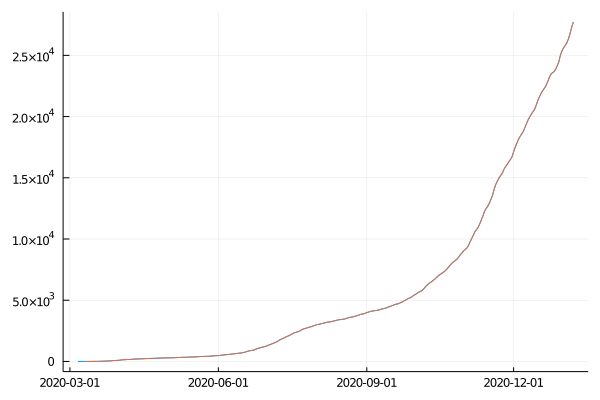

In [5]:
@df df plot(:date, :cases_inferred, legend=false)
@df df plot!(:date, :cases)

In [6]:
ws = append!(collect(1/15:1/15:14/15), ones(14))
growth = Float64[]
active_cases = Float64[]
for i in 1:length(axes(df, 1))
    cases_yesterday = i > 1 ? df[i-1, :cases_inferred] : 0
    cases_today = df[i, :cases_inferred]
    push!(growth, cases_today - cases_yesterday)
    push!(active_cases,
        round(sum(
            [j < 1 ? 0 : growth[j] for j in i-27:i] .* ws
        ))
    )
end
df.growth = growth
df.active_cases = active_cases
last(df, 30)

,date,day,cases,cases_inferred,growth,active_cases
,Date,Int64,Int64?,Float64?,Float64,Float64
1,2020-12-09,279,19430,19430.0,323.0,5742.0
2,2020-12-10,280,19739,19739.0,309.0,5761.0
3,2020-12-11,281,19981,19981.0,242.0,5723.0
4,2020-12-12,282,20203,20203.0,222.0,5676.0
5,2020-12-13,283,20402,20402.0,199.0,5609.0
6,2020-12-14,284,20588,20588.0,186.0,5526.0
7,2020-12-15,285,20933,20933.0,345.0,5593.0
8,2020-12-16,286,21319,21319.0,386.0,5696.0
9,2020-12-17,287,21613,21613.0,294.0,5708.0


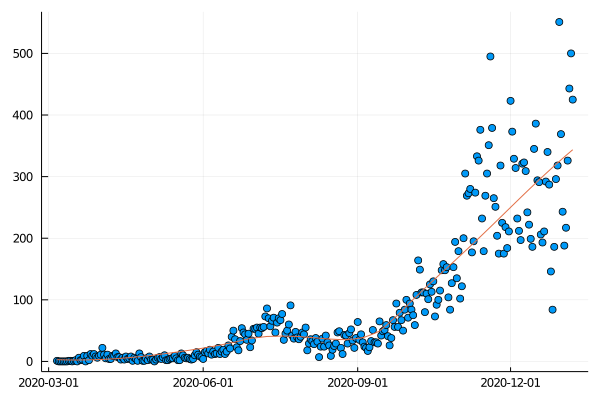

In [7]:
growth_model = loess(df[:, :day], convert(Array{Float64}, df[:, :growth]));
@assert all_dates[1] == minimum(all_dates)
predicted_growth(day) = predict(growth_model, [(day - all_dates[1]).value + 1.0]);
@df df scatter(:date, :growth, legend=false)
plot!(all_dates, predicted_growth.(all_dates))

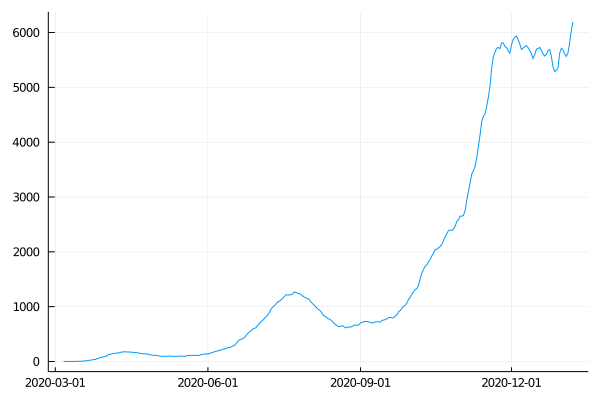

In [8]:
@df df plot(:date, :active_cases, legend=false)

In [9]:
davis_county_population = 356_000
current_growth = predicted_growth(all_dates[end])
@printf("Current growth: %12.2f\nYears to infect all: %7.2f\nActive cases: %11d",
    current_growth,
    davis_county_population / current_growth / 365,
    df.active_cases[end])

Current growth:       343.65
Years to infect all:    2.84
Active cases:        6192

```





```